In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.rdd import portable_hash
from pyspark.statcounter import StatCounter
from pyspark.sql.functions import lit, desc, col, when, max
from functools import reduce
import os
import json
from datetime import datetime
from operator import itemgetter
#from itertools import chain, imap
from shapely.geometry import shape, Point
from matplotlib import pyplot as plt
spark = SparkSession.builder.appName("Taxi")\
        .config("spark.driver.memory", "6g")\
        .config("spark.driver.cores", "8")\
        .getOrCreate()
sc=spark.sparkContext
from  pprint import pprint
def title(s):
    pprint("---- %s -----" %s)    
    
def see(s, v):
    pprint("---- %s -----" %s)
    pprint(v)

In [2]:
DATA_DIR = "./geospatial"

In [3]:
taxiRawAll = sc.textFile(DATA_DIR+"/trip_data_1.csv.gz")
header = sc.parallelize(taxiRawAll.take(1))
taxiRaw = taxiRawAll.sample(withReplacement=False, fraction=0.001 ,seed=17)
header.collect()
taxiH = header.union(taxiRaw)
oneFileRdd = taxiH.coalesce(1)
oneFileRdd.saveAsTextFile("trip_data_sample_wheader.csv")
taxiH = sc.parallelize(taxiRawAll.take(14000))

In [4]:
df = spark.read.csv("trip_data_sample_wheader.csv",header=True)

In [5]:
df.createOrReplaceTempView("taxi")
sqlQuery = "select * FROM taxi"

In [6]:
with open(DATA_DIR+'/nyc-boroughs.geojson', 'r') as f:
        geo = json.load(f)
features = geo['features']
for f in features:
    f["shape"] = shape(f['geometry'])
areaSortedFeatures = sorted(features, key=lambda f: (int(f['properties']["boroughCode"]), -f["shape"].area), reverse=False)

In [7]:
bFeatures = sc.broadcast(areaSortedFeatures)

In [8]:
def borough(t1,t2):
    try:
        trip=Point(float(t1),float(t2))
    except:
        return None
    for f in bFeatures.value:
        #contains checks if the 
        if f['shape'].contains(trip):
            return str(f['properties']["borough"])
    return None
spark.udf.register("borough", borough)
sqlQuery = "select *,borough(pickup_longitude,pickup_latitude) as Pickup_Location,\
borough(dropoff_longitude,dropoff_latitude) as Dropoff_Location FROM taxi"
spark.sql(sqlQuery).createOrReplaceTempView("taxi")

Case 1

In [9]:
t = spark.sql("select count(vendor_id) from taxi").first()[0]
sqlQuery ="select vendor_id as Vendor,count(vendor_id)*100/{0} as Market_Share from taxi group by vendor_id".format(t)
table1=spark.sql(sqlQuery)

In [10]:
case1=table1.toPandas()
case1

,Vendor,Market_Share
0,CMT,50.462711
1,VTS,49.537289


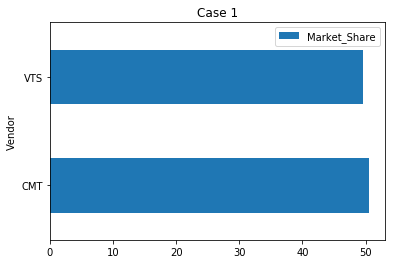

In [11]:
case1.plot.barh(stacked=True,title='Case 1',x='Vendor')

Case 2

In [12]:
sqlQuery ="select vendor_id as Vendor,rate_code as Rate,count(rate_code) as Count from taxi \
group by vendor_id,rate_code order by vendor_id,rate"
table2=spark.sql(sqlQuery)

In [13]:
case2 = table2.selectExpr('*').groupBy('Rate').pivot('Vendor').sum('Count').sort("Rate").fillna(0)
case2.show(10)

+----+----+----+
|Rate| CMT| VTS|
+----+----+----+
|   0|   1|   0|
|   1|7254|7087|
|   2| 120| 145|
|   3|   5|  10|
|   4|  20|  10|
|   5|  16|  28|
+----+----+----+



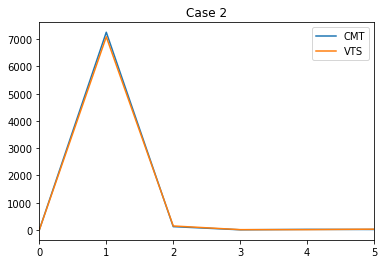

In [14]:
case2.toPandas().plot(title='Case 2')

case 3

In [15]:
sqlQuery ="select HOUR(pickup_datetime) as Hour_ID,rate_code as Rate,count(rate_code) as Count from taxi \
group by pickup_datetime,rate_code order by pickup_datetime,rate_code"
spark.sql(sqlQuery).createOrReplaceTempView("taxi3")
table3=spark.sql(sqlQuery)

In [16]:
sqlQuery ="select Hour_ID,Rate,sum(Count) as Total_Count from taxi3 \
group by Hour_ID,Rate order by Hour_ID,Rate"
#spark.sql(sqlQuery).show(10)
table3 = spark.sql(sqlQuery)
case3 = table3.selectExpr('*').groupBy('Hour_ID').pivot('Rate').sum('Total_Count').sort("Hour_ID").fillna(0)
case3.show()

+-------+---+---+---+---+---+---+
|Hour_ID|  0|  1|  2|  3|  4|  5|
+-------+---+---+---+---+---+---+
|      0|  0|536|  7|  0|  2|  6|
|      1|  0|389|  5|  0|  0|  2|
|      2|  0|333|  0|  0|  0|  3|
|      3|  0|228|  0|  0|  0|  1|
|      4|  0|150|  8|  1|  1|  1|
|      5|  0|132|  7|  1|  1|  1|
|      6|  0|287| 12|  3|  0|  2|
|      7|  0|556| 12|  1|  3|  1|
|      8|  0|701|  7|  0|  2|  1|
|      9|  0|661|  4|  1|  3|  0|
|     10|  1|665|  8|  1|  0|  1|
|     11|  0|747|  9|  2|  0|  0|
|     12|  0|722| 13|  0|  1|  1|
|     13|  0|710| 21|  0|  1|  0|
|     14|  0|709| 22|  0|  1|  1|
|     15|  0|651| 27|  3|  0|  4|
|     16|  0|618| 18|  0|  1|  3|
|     17|  0|821| 17|  0|  2|  1|
|     18|  0|879| 13|  1|  2|  1|
|     19|  0|923| 12|  0|  2|  1|
+-------+---+---+---+---+---+---+
only showing top 20 rows



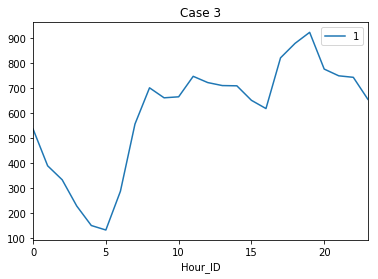

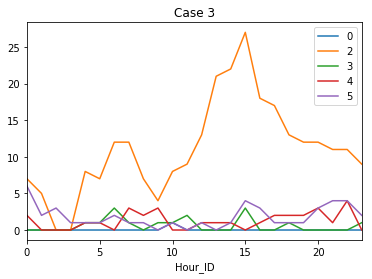

In [17]:
case3.toPandas().plot(title='Case 3',x='Hour_ID',y=['1'])
case3.toPandas().plot(title='Case 3',x='Hour_ID',y=['0','2','3','4','5'])

Case 4

In [18]:
sqlQuery ="select Pickup_Location,Avg(trip_distance) as Avg_dist from taxi group by Pickup_Location "
spark.sql(sqlQuery).show(10)
table4 = spark.sql(sqlQuery)

+---------------+------------------+
|Pickup_Location|          Avg_dist|
+---------------+------------------+
|         Queens|10.160263522884884|
|           null|2.7486241610738267|
|       Brooklyn|3.6275418994413404|
|  Staten Island|              2.98|
|      Manhattan| 2.382660350402285|
|          Bronx|3.7472222222222222|
+---------------+------------------+



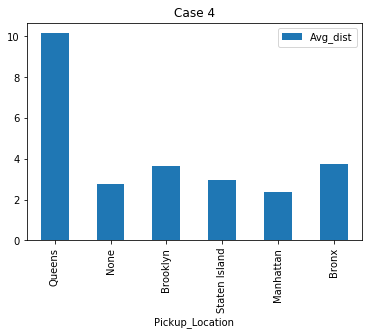

In [19]:
table4.toPandas().plot(kind='bar',x='Pickup_Location',y='Avg_dist',title='Case 4')

Case 5

In [20]:
sqlQuery ="select *,trip_distance/(trip_time_in_secs/3600) as Speed from taxi"
spark.sql(sqlQuery).createOrReplaceTempView("temptaxi5")

In [21]:
sqlQuery ="select Pickup_Location,(avg(Speed)) as Avg_Speed from temptaxi5 group by Pickup_Location"
spark.sql(sqlQuery).show(5)
table5=spark.sql(sqlQuery)

+---------------+------------------+
|Pickup_Location|         Avg_Speed|
+---------------+------------------+
|         Queens| 34.90035368768957|
|           null|13.506115318867176|
|       Brooklyn| 15.93413382412576|
|  Staten Island| 7.025281724644781|
|      Manhattan|13.347089277063805|
+---------------+------------------+
only showing top 5 rows



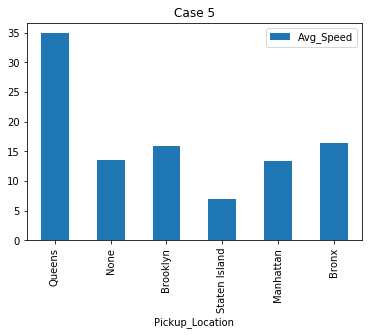

In [22]:
table5.toPandas().plot(kind='bar',x='Pickup_Location',title='Case 5')

case 6

In [23]:
sqlQuery ="select passenger_count as Passenger,avg(trip_distance) as Avg_Distance,\
max(trip_distance) as Max_Distance from taxi group by passenger_count order by passenger_count"
spark.sql(sqlQuery).show(5)
table6 = spark.sql(sqlQuery)

+---------+------------------+------------+
|Passenger|      Avg_Distance|Max_Distance|
+---------+------------------+------------+
|        1|2.7420896809427995|        9.99|
|        2|2.9147357926221327|        9.98|
|        3|2.9605084745762715|        9.80|
|        4|2.8322183098591576|        9.90|
|        5| 3.048636897767334|        9.92|
+---------+------------------+------------+
only showing top 5 rows



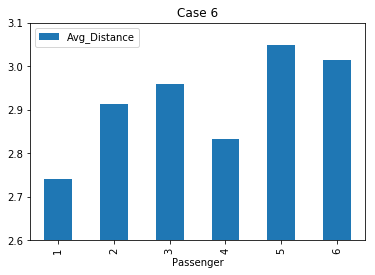

In [24]:
table6.toPandas().plot(kind='bar',ylim=(2.6,3.1),title='Case 6',x='Passenger',y='Avg_Distance')

Case 7

In [25]:
sqlQuery ="select CONCAT(day(pickup_datetime),'-',Month(pickup_datetime)) as Date,\
CONCAT(Pickup_Location,'-',Dropoff_Location) as Pairs,\
count(vendor_id) as Count from taxi where Pickup_Location != Dropoff_Location group by Date,Pairs \
order by Date,Pairs"
table7=spark.sql(sqlQuery)
case7 = table7.selectExpr('*').groupBy('Date').pivot('Pairs').sum('Count').sort("Date").fillna(0)
case7.toPandas()

,Date,Bronx-Manhattan,Brooklyn-Manhattan,Brooklyn-Queens,Manhattan-Bronx,Manhattan-Brooklyn,Manhattan-Queens,Queens-Bronx,Queens-Brooklyn,Queens-Manhattan
0,1-1,4,5,0,2,17,21,2,3,12
1,10-1,0,6,0,0,17,17,0,1,12
2,11-1,2,4,0,0,14,15,0,2,16
3,12-1,0,5,1,3,18,12,0,3,15
4,13-1,0,6,1,3,17,12,0,3,23
5,14-1,0,2,1,0,10,13,0,3,18
6,15-1,0,3,1,4,13,17,0,1,20
7,16-1,1,4,1,0,15,13,1,2,16
8,17-1,0,6,0,1,13,15,0,2,11
9,18-1,0,7,0,1,21,20,0,2,14


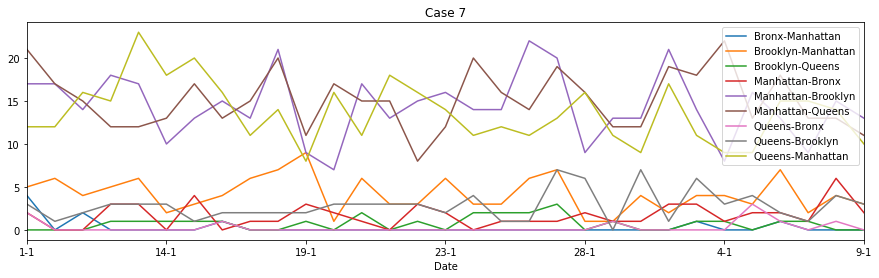

In [26]:
case7.toPandas().plot(title='Case 7',x='Date',figsize=(15,4))